In [1]:
from functions import *

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import seaborn as sns
import os
import osmnx as ox
import numpy as np
import datetime
import networkx as nx
import json
import math
from tqdm import tqdm_notebook
tqdm_notebook().pandas()
%matplotlib inline



#### let's get test and train sets

In [2]:
train_data = pd.read_csv('train_set.csv')
test_data = pd.read_csv('test_set.csv')

In [3]:
# let's get graph
porto_graph = get_graph()

#### Let's now transform our trip by trip data into a 1-D array of links traversed (as they are reported across all taxis), sorted by the timestamp. This is necessary as this new 1-D list of lists is what will be used by the kalman filter.

In [4]:
sorted_reported_data = transform_into_kalman_input(train_data)

In [5]:
# let's make our test data ready
sorted_test_data = transform_into_kalman_input(test_data)

#### For the first kalman filter, let's just say the next state of the travel times is the same as the previous state.

In [6]:
# Kalman filter predict function for this version

def make_predict_matrices(links_of_interest):
    state_size = len(links_of_interest.keys())
    # we will say next state is same as previous state here
    A = np.eye(state_size,dtype=int)
    return A



In [17]:
# initialise state matrices
links_of_interest = return_links_of_interest(porto_graph)
state_size = len(links_of_interest.keys())

# let's initialise the travel times for each road to be the average_length/average_speed
# if we assume average speed is 30mph (as speed limit is 50mph) -> this corresponds to 13.3 m/s

# Running the code below would give an average time of 13.429 seconds per link

# simplified_graph = ox.simplify_graph(porto_graph, strict=True)
# edge_data = return_edge_data(simplified_graph)
# lengths = []
# for key, value in edge_data.items():
#     if key in links_of_interest:
#         lengths.append(value['length'])
# average_length = sum(lengths)/(len(lengths))
# average_time = average_length/13.3

average_time = 13.429
X = np.full((state_size, 1), average_time)
std = 5
variance = std*std
P = np.eye(state_size)*variance
# set P to give each state an std of 5 seconds
A = make_predict_matrices(links_of_interest)

In [18]:
print(X.shape)

(3368, 1)


In [19]:
print(np.dot(A, X).shape)

(3368, 1)


In [20]:
# now let's iterate through the reportings and run a predict, update after every 5 minute block

start_timestamp = 1399392010
last_timestamp = 1399392010
last_index = 0

# let's store the performances for plotting
estimation_performance_store = [[]]
estimated_average_X_store = [[]]
actual_average_congestion = [[]]
current_week = 0

while last_index<len(sorted_reported_data):
    new_week= False
    current_estimated_average = np.mean(X)
    print('Current Average: {}'.format(current_estimated_average))
    estimated_average_X_store[current_week].append(current_estimated_average)
    # measure the performance using our current prediction
    estimation_performance = measure_performance(sorted_test_data, last_timestamp, X,links_of_interest)
    print('Estimation Performance: {}'.format(estimation_performance))
    estimation_performance_store[current_week].append([last_timestamp,estimation_performance])
    # now run update using measurments and predict for next block
    (Y, H, N, last_index, last_timestamp, new_week) = make_measurement_matrices(last_index, last_timestamp, sorted_reported_data, links_of_interest)
    # count how many roads we got info for in current 5 minute block
    num_roads = np.count_nonzero(H.sum(axis=0))
    print('Received information for {} roads'.format(num_roads))
    (X,P) = kalman_update(X, P, Y, H, N)
    (X,P) = kalman_predict(X,P,A) 
    if new_week == True:
        break
        estimation_performance_store.append([])
        current_week+=1
        
    

Current Average: 13.429
Estimation Performance: 11.661001665263711
Received information for 115 roads
Current Average: 13.345425701563778
Estimation Performance: 13.492757357945875
Received information for 328 roads
Current Average: 12.945496437365204
Estimation Performance: 12.884963269655668
Received information for 309 roads
Current Average: 12.691024184170312
Estimation Performance: 11.958072771098763
Received information for 229 roads
Current Average: 12.573573398496976
Estimation Performance: 11.58115676697208
Received information for 333 roads
Current Average: 12.416187857539333
Estimation Performance: 10.34756908131815
Received information for 349 roads
Current Average: 12.20131409563172
Estimation Performance: 12.110406227141649
Received information for 339 roads
Current Average: 12.206140872145623
Estimation Performance: 12.702330039619278
Received information for 313 roads
Current Average: 12.19222359847376
Estimation Performance: 10.325119024263032
Received information for 

### When a new week starts, plot the measurements on a new graph

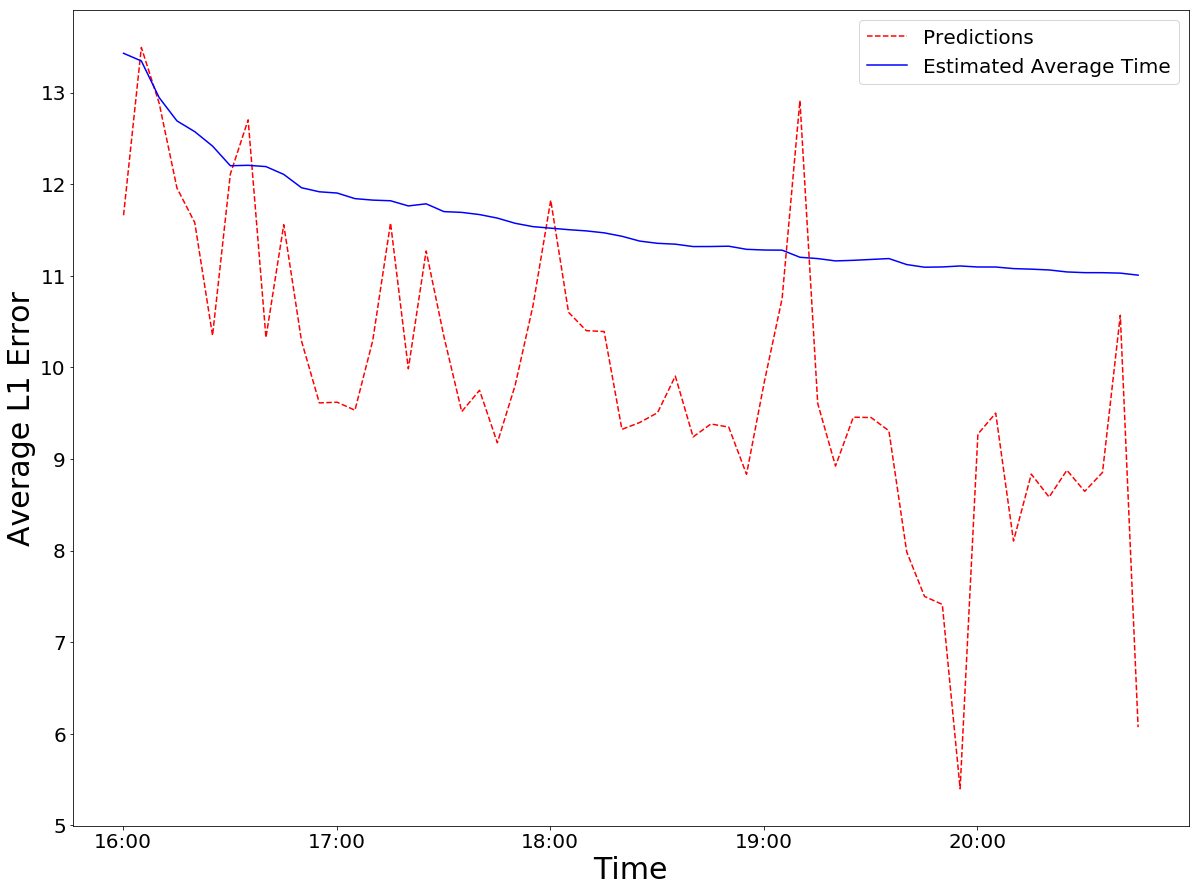

In [22]:
plt.figure(figsize=(20,15))
week_index=0
week_estimation_performances = estimation_performance_store[week_index][:-4]
# need to convert timestamps to plottable format
estimation_timestamps_plot = dates.date2num([datetime.datetime.utcfromtimestamp(x[0]) for x in week_estimation_performances])
estimated_averages = estimated_average_X_store[0]
estimation_values = [x[1] for x in week_estimation_performances]
plt.plot_date(estimation_timestamps_plot, estimation_values, 'r--', label = 'Predictions')
plt.plot_date(estimation_timestamps_plot, estimated_averages[:-4], 'b', label = 'Estimated Average Time')
plt.legend(prop={'size': 20})
plt.gca().xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
plt.ylabel('Average L1 Error', fontsize=30)
plt.xlabel('Time', fontsize= 30)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()